# Install Libraries

In [1]:
%pip install datasets
%pip install -q git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Import Dependencies

In [2]:
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import torch
from PIL import Image
import io

# Notebook for Testing Model Results

We trained two separate models, one on a smaller dataset (test_model) for 4 epochs, which took about 2 hours, and one for 2 epochs on the full dataset (train_model), which took over 7 hours. Due to constraints on our compute resources, we were unable to train for further epochs, but using the Nvidia A100 on colab at least allowed us to train without swamping our GPU RAM. The test_model achieved a loss rate of ~51%, and the train_model ~50%. In this notebook, we test the results on the val split to decide which model yields better results. The first 9 cells are largely dedicated to preparing the data and downloading the models, and the actual test results are contained in the final two cells.

In [3]:
sidewalk_test = load_dataset("back2classroom/sidewalks", split='val', streaming=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
test_images = []
test_labels = []

# Loop through the streamed dataset and collect images and masks
for sample in sidewalk_test:
    test_images.append(sample['tif'])
    test_labels.append(sample['label_tif'])

# Decode a JPEG byte string to a NumPy array
def decode_jpeg_to_array(jpeg_bytes):
    with io.BytesIO(jpeg_bytes) as byte_stream:
        image = Image.open(byte_stream)
        return np.array(image)

valid_indices = []
false_counter = 0

for i, mask_bytes in enumerate(test_labels):
    mask_np = decode_jpeg_to_array(mask_bytes)
    # Check if any pixel in the mask is not zero
    if np.any(mask_np != 0):
        valid_indices.append(i)
    else:
        false_counter += 1

print("Empty masks: ", false_counter)


filtered_images = [test_images[i] for i in valid_indices]
filtered_masks = [test_labels[i] for i in valid_indices]

Empty masks:  9917


In [5]:
# Convert byte arrays to numpy arrays
def convert_to_numpy(byte_data):
    with io.BytesIO(byte_data) as byte_stream:
        image = Image.open(byte_stream)
        image_np = np.array(image)
        return image_np

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [6]:
dataset_dict = {
    "image": filtered_images,  # Directly use the byte data
    "label": filtered_masks,   # Directly use the byte data
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

# Test Dataset Load

Sanity check to ensure data was loaded and indexed properly

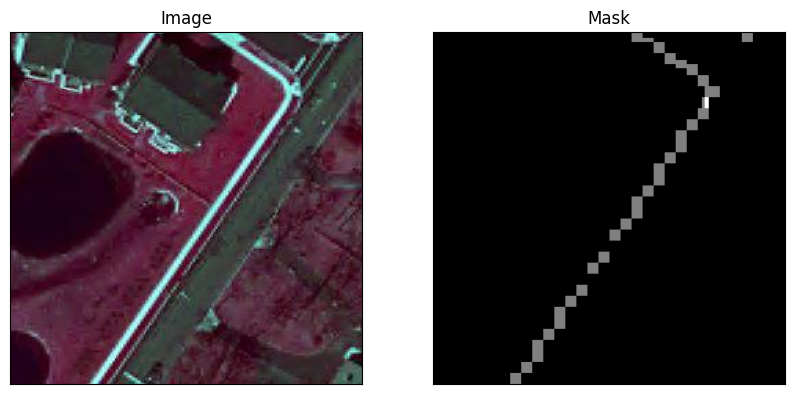

In [8]:
img_num = random.randint(0, convert_to_numpy(filtered_images[0]).shape[0]-1)

image_np = dataset[img_num]["image"]
mask_np = dataset[img_num]["label"]

image_np = convert_to_numpy(image_np)
mask_np = convert_to_numpy(mask_np)

example_image = Image.fromarray(image_np)
example_mask = Image.fromarray(mask_np)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# Inference Testing

In [9]:
from transformers import SamModel, SamConfig, SamProcessor

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [10]:
test_model_path = "/content/drive/MyDrive/Colab Notebooks/model_checkpoint_trained_on_test.pth"
train_model_path = "/content/drive/MyDrive/Colab Notebooks/model_checkpoint_trained_on_train.pth"

# Create an instance of the model architecture with the loaded configuration
test_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
test_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/model_checkpoint_trained_on_test.pth"))

# Create an instance of the model architecture with the loaded configuration
train_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
train_model.load_state_dict(torch.load(train_model_path))

<All keys matched successfully>

In [11]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
test_model.to(device)
train_model.to(device)
print(device)

cuda


# Convenience Function to Visualize Results

In [23]:
def visualize_segmentation_example(dataset, test_model, processor, device):
    """
    Visualizes a segmentation example from the dataset using the provided model and processing functions.

    Args:
        dataset (Dataset): A HF list of data samples containing images and labels.
        test_model (torch.nn.Module): The segmentation model to be used for inference.
        processor: The pre-processing function for the model input.
        device: The device (CPU or GPU) to perform inference on.
    """
    # Let's take a random training example
    idx = random.randint(0, convert_to_numpy(filtered_images[0]).shape[0] - 1)

    # Load image
    test_image = Image.fromarray(convert_to_numpy(dataset[idx]["image"]))

    # Get box prompt based on ground truth segmentation map
    ground_truth_mask = convert_to_numpy(dataset[idx]["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # Prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}

    test_model.eval()

    # Forward pass
    with torch.no_grad():
        outputs = test_model(**inputs, multimask_output=False)

    # Apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # Convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
    axes[0].set_title("Original Image")

    # Plot the first image on the left
    axes[1].imshow(np.array(ground_truth_mask), cmap='gray')  # Assuming the first image is grayscale
    axes[1].set_title("Original Mask")

    # Plot the second image on the right
    axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
    axes[2].set_title("Predicted Mask")

    # Plot the third image on the right
    axes[3].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
    axes[3].set_title("Predicted Probability Map")

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()


# Test Model Trained on Smaller Dataset

A simple visual test to see performance of test_model (trained on smaller dataset). The original image, the original mask, the predicted mask, and the predicted probability map output by the model are displayed side by side. As we can see, the model achieved very good results despite being finetuned on a smaller dataset

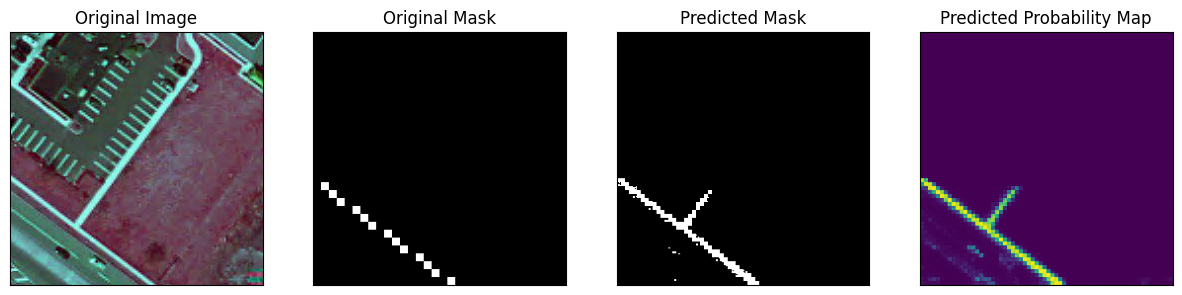

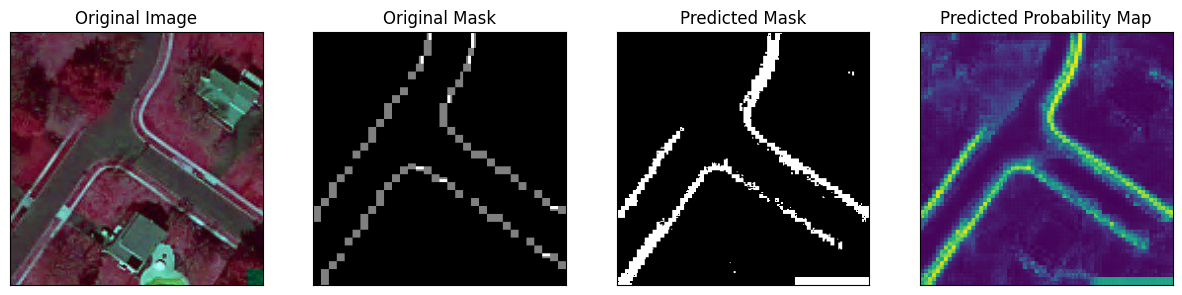

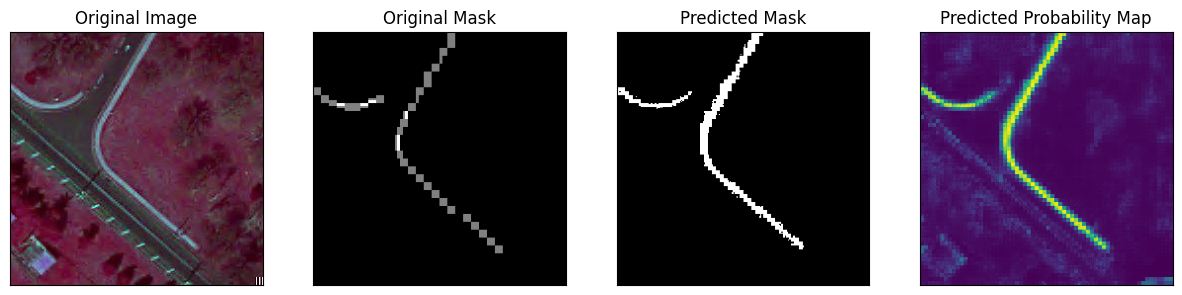

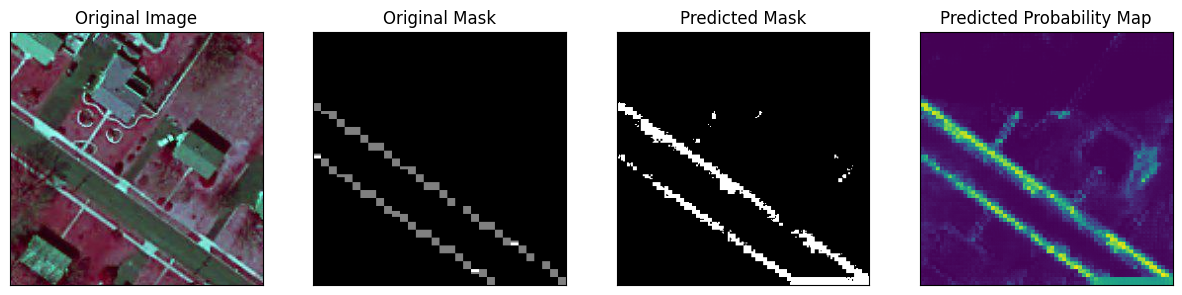

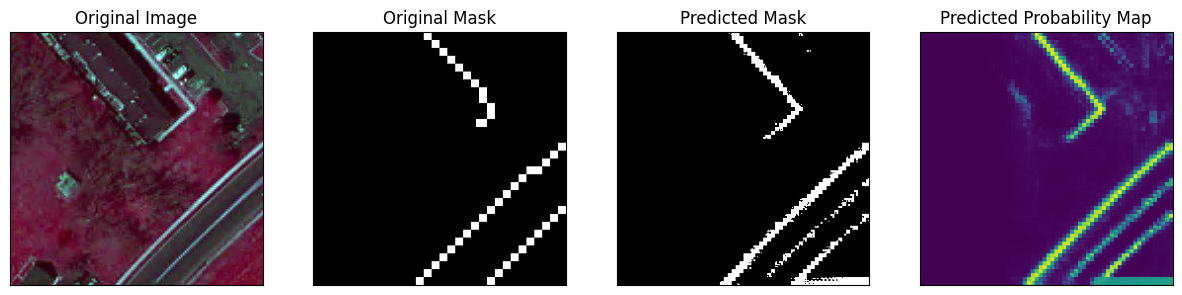

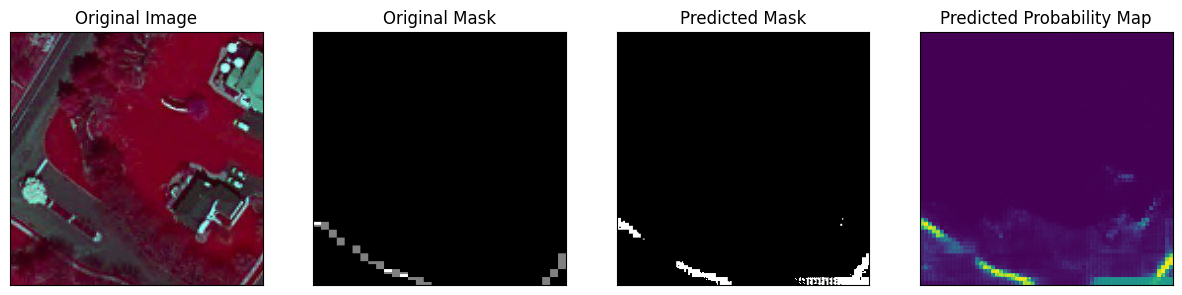

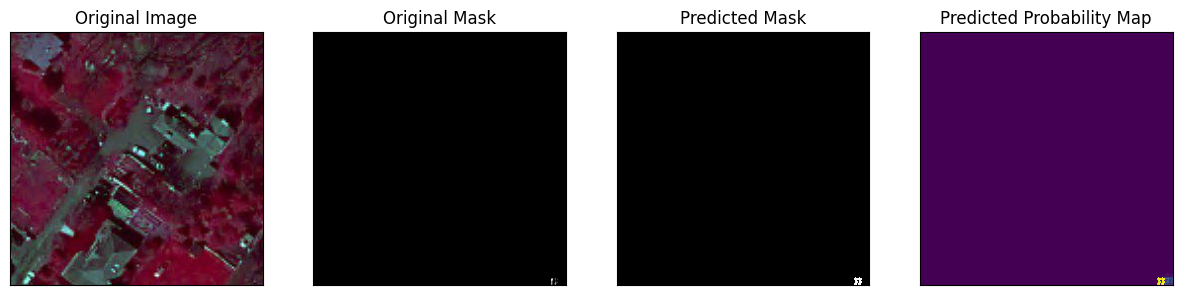

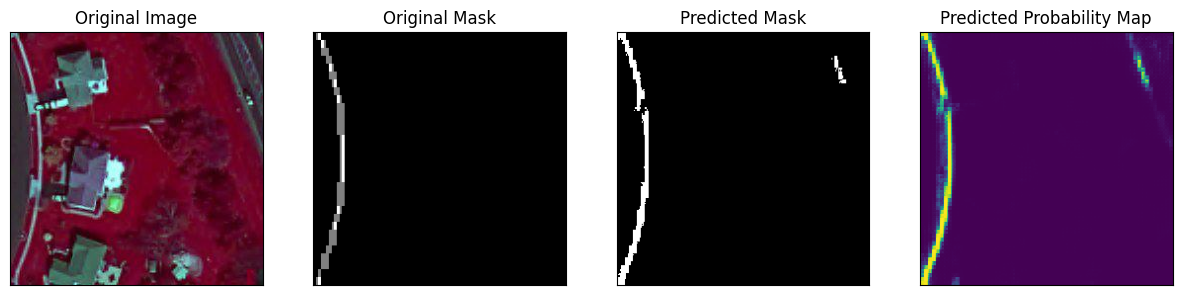

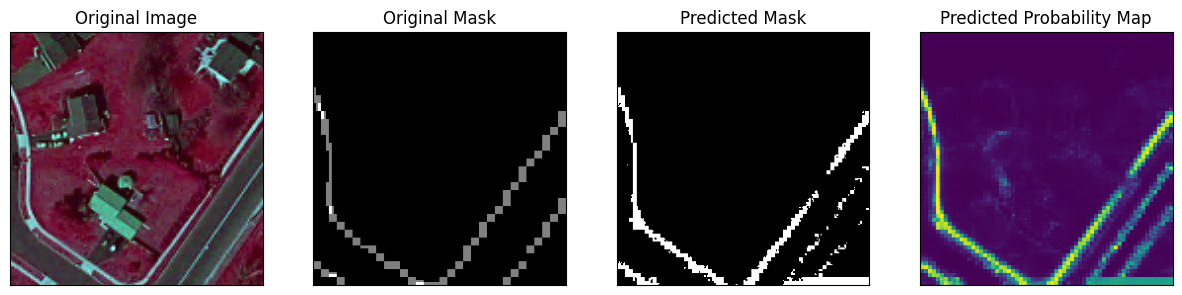

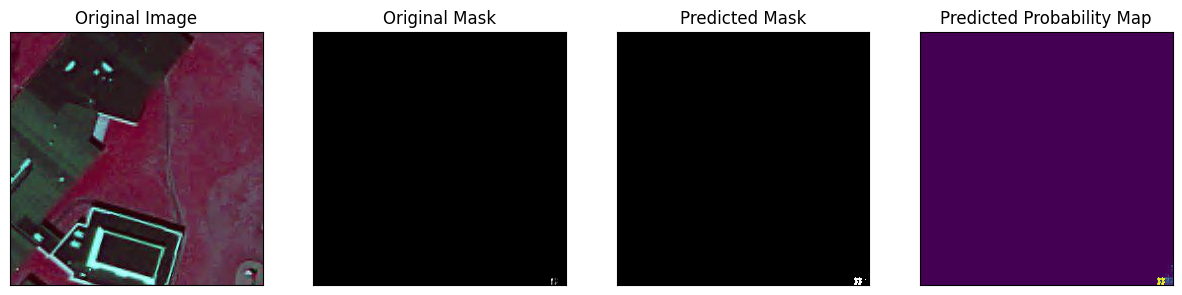

In [24]:
for i in range(10):
  visualize_segmentation_example(dataset, test_model, processor, device)


# Test Model Trained on Full Datset

A simple visual test to see performance of train_model (trained on full dataset). Method is the same as above, with the original image, the given mask label, the predicted mask, and the predicted probability map displayed. The results are similar to the test_model, and notice that it sometimes outperforms the given mask. More importantly, due to the larger dataset, we believe that this model will be more generalizable than the test_model, so we chose to use this model for our web app.

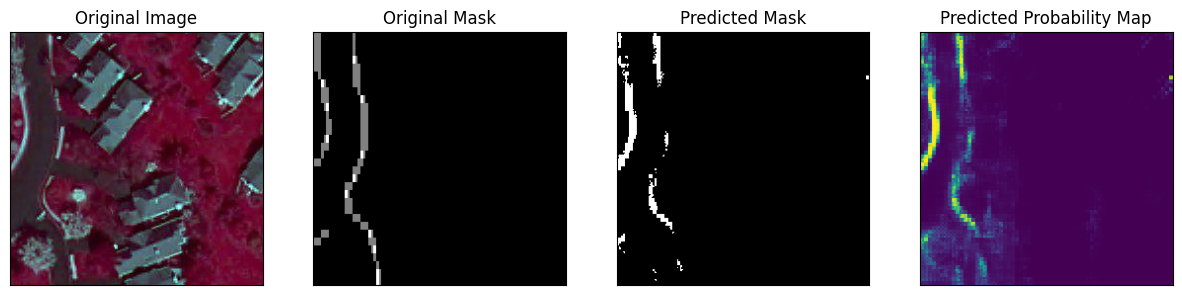

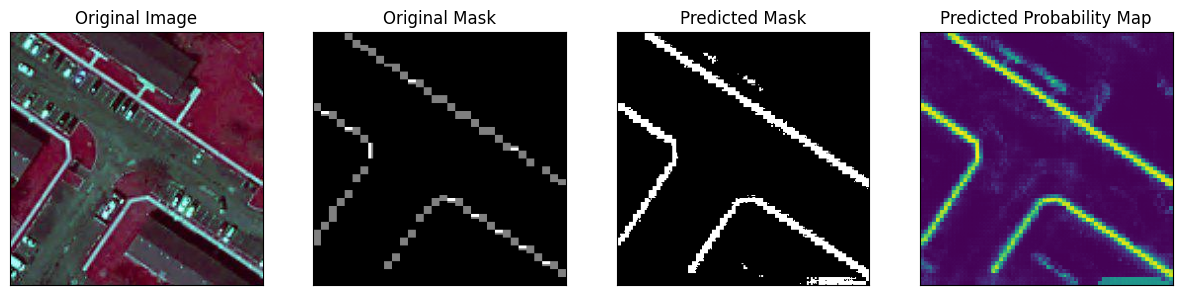

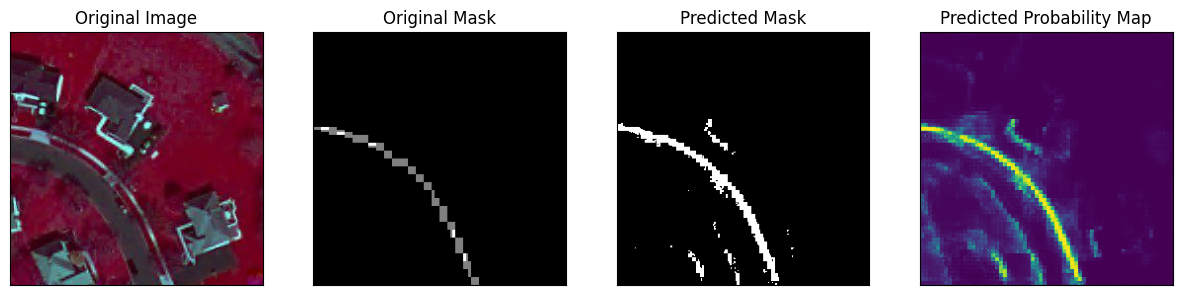

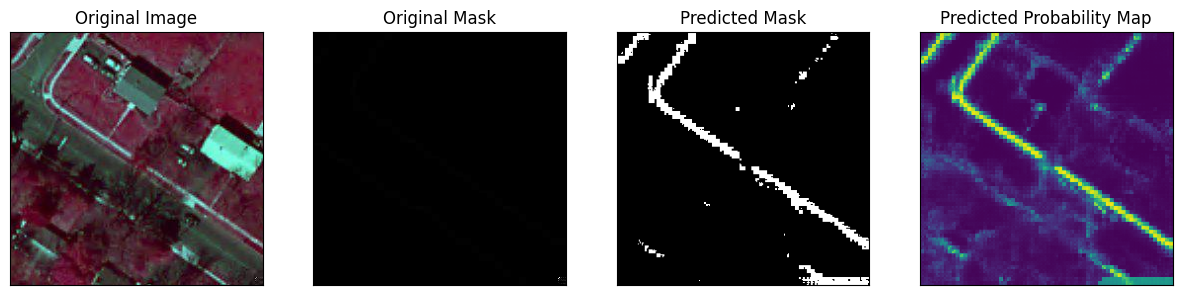

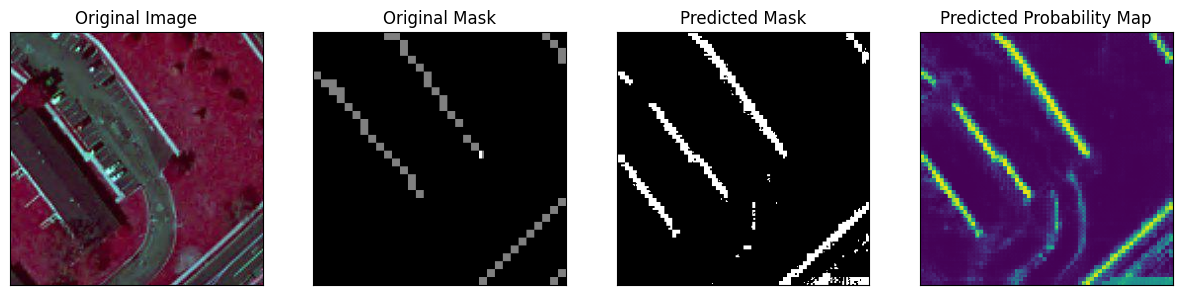

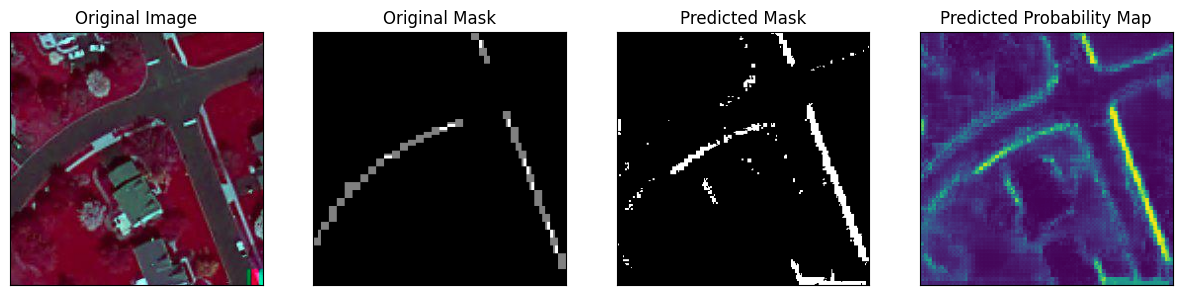

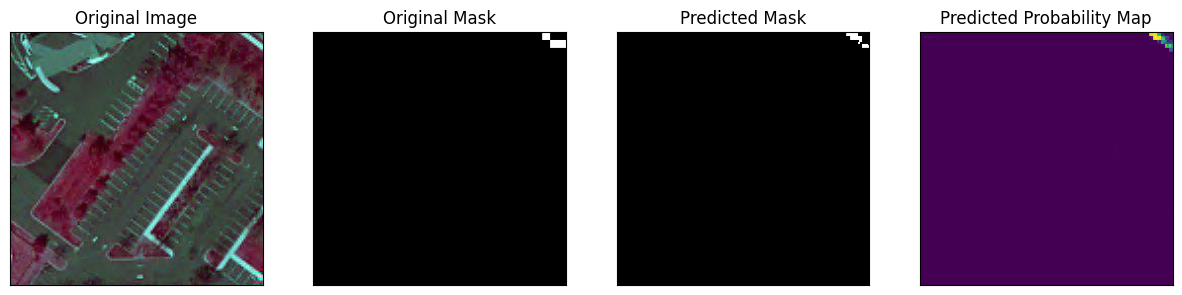

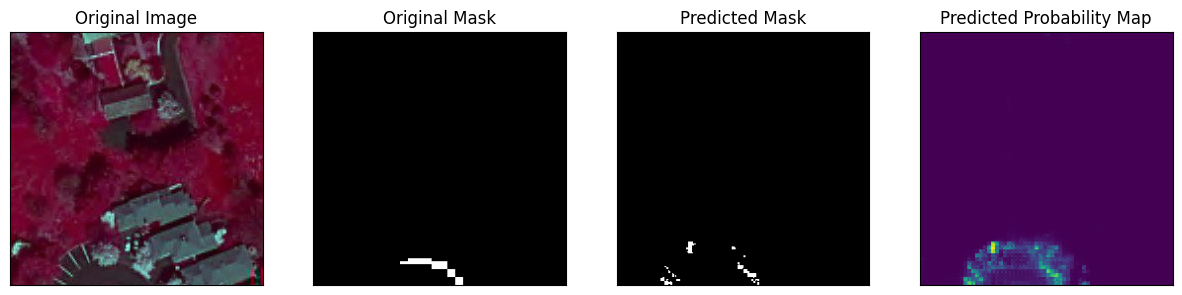

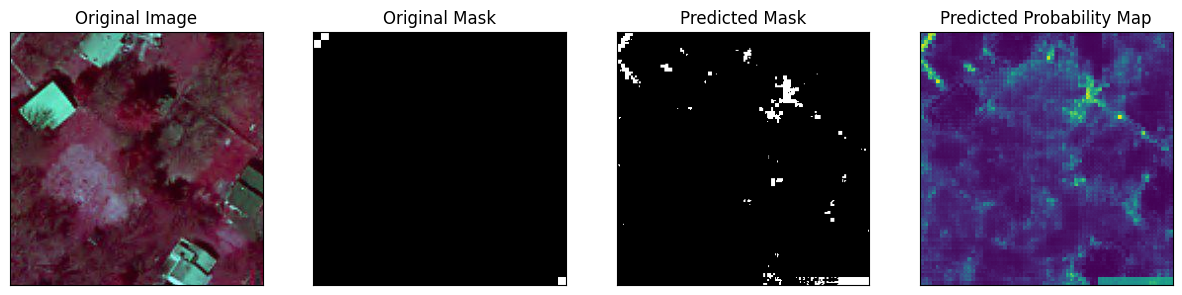

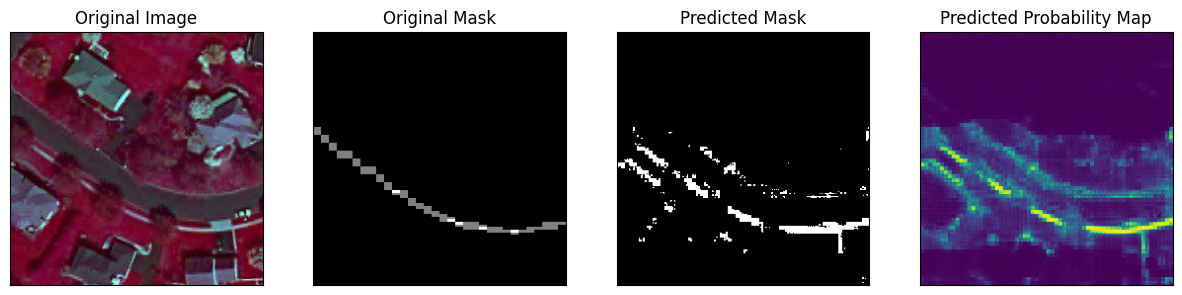

In [25]:
for i in range(10):
  visualize_segmentation_example(dataset, train_model, processor, device)

# IoU Testing

In [43]:
'''
def get_IoU(dataset, test_model, processor, device):
    """
    Calculate intersection over union metric using given and predicted binary masks.

    Args:
        dataset (Dataset): A HF list of data samples containing images and labels.
        test_model (torch.nn.Module): The segmentation model to be used for inference.
        processor: The pre-processing function for the model input.
        device: The device (CPU or GPU) to perform inference on.
    """
    # Let's take a random training example
    idx = random.randint(0, convert_to_numpy(filtered_images[0]).shape[0] - 1)

    # Load image
    test_image = Image.fromarray(convert_to_numpy(dataset[idx]["image"]))

    # Get box prompt based on ground truth segmentation map
    ground_truth_mask = convert_to_numpy(dataset[idx]["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # Prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}

    test_model.eval()

    # Forward pass
    with torch.no_grad():
        outputs = test_model(**inputs, multimask_output=False)

    # Apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # Convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    cur_intersection = 0
    cur_union = 0
    for medsam, gt in np.nditer([medsam_seg, ground_truth_mask]):
      if medsam == 1 and gt == 1:
        cur_intersection += 1
      if medsam == 1 or gt == 1:
        cur_union += 1


    print(cur_intersection, cur_union)
    print(cur_intersection/float(cur_union))
    '''

In [47]:
def get_IoU(dataset, test_model, processor, device):
    """
    Calculate intersection over union metric using given and predicted binary masks.

    Args:
        dataset (Dataset): A HF list of data samples containing images and labels.
        test_model (torch.nn.Module): The segmentation model to be used for inference.
        processor: The pre-processing function for the model input.
        device: The device (CPU or GPU) to perform inference on.
    """
    intersection_sum = 0
    union_sum = 0
    total_samples = len(dataset)

    test_model.eval()

    for idx in range(total_samples):
        # Load image
        test_image = Image.fromarray(convert_to_numpy(dataset[idx]["image"]))

        # Get box prompt based on ground truth segmentation map
        ground_truth_mask = convert_to_numpy(dataset[idx]["label"])
        prompt = get_bounding_box(ground_truth_mask)

        # Prepare image + box prompt for the model
        inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

        # Move the input tensor to the GPU if it's not already there
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = test_model(**inputs, multimask_output=False)

        # Apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        # Convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        cur_intersection = 0
        cur_union = 0
        for medsam, gt in np.nditer([medsam_seg, ground_truth_mask]):
          if medsam == 1 and gt == 1:
            cur_intersection += 1
          if medsam == 1 or gt == 1:
            cur_union += 1

        intersection_sum += cur_intersection
        union_sum += cur_union

    IoU = intersection_sum / union_sum
    print("Mean Intersection over Union (IoU):", IoU)



In [48]:
get_IoU(dataset, test_model, processor, device)

Mean Intersection over Union (IoU): 0.34707865654054165


In [49]:
get_IoU(dataset, train_model, processor, device)

Mean Intersection over Union (IoU): 0.35790678216225125


In [51]:
def get_IoU_with_bg(dataset, test_model, processor, device):
    """
    Calculate intersection over union metric using given and predicted binary masks.

    Args:
        dataset (Dataset): A HF list of data samples containing images and labels.
        test_model (torch.nn.Module): The segmentation model to be used for inference.
        processor: The pre-processing function for the model input.
        device: The device (CPU or GPU) to perform inference on.
    """
    intersection_sum = 0
    #union_sum = 0
    total_samples = len(dataset)

    test_model.eval()

    for idx in range(total_samples):
        # Load image
        test_image = Image.fromarray(convert_to_numpy(dataset[idx]["image"]))

        # Get box prompt based on ground truth segmentation map
        ground_truth_mask = convert_to_numpy(dataset[idx]["label"])
        prompt = get_bounding_box(ground_truth_mask)

        # Prepare image + box prompt for the model
        inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

        # Move the input tensor to the GPU if it's not already there
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = test_model(**inputs, multimask_output=False)

        # Apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        # Convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        cur_intersection = np.sum(medsam_seg == ground_truth_mask)
        #cur_union = np.sum(np.logical_or(medsam_seg, ground_truth_mask))

        intersection_sum += cur_intersection
        #union_sum += cur_union

    union_sum = 256 * 256 * 10000
    IoU = intersection_sum / union_sum
    print("Mean Intersection over Union (IoU) including background:", IoU)

In [52]:
get_IoU_with_bg(dataset, test_model, processor, device)

Mean Intersection over Union (IoU) including background: 0.9724627960205078


In [ ]:
get_IoU_with_bg(dataset, train_model, processor, device)